* # Douban movie reviews analysis


## 1.Pre-processing

We have added some steps about data preprocessing to make the data cleaner and better processed. We deleted the duplicated comments and made a moive stop-word list.

In [46]:
import ipykernel

ipykernel.__version__

'6.9.1'

In [47]:
import numpy as np
import pandas as pd
import jieba
import re

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from gensim.corpora import Dictionary

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
import gensim
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec
from nltk.tokenize import word_tokenize
from gensim import corpora, models, similarities
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

# For the first-time user, you should download these two pre-trained tokenizer
#nltk.download('punkt') 
#nltk.download('stopwords')

import numpy as np
import pandas as pd

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.metrics import r2_score

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
nltk.download('wordnet')
nltk.download('omw-1.4')


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fy_laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fy_laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [48]:
data = pd.read_csv("doubanmovieshortcomments/movie_comment.csv", on_bad_lines='skip')

In [49]:
# check whether there are nan values

data.isna().sum()

Movie_Name_CN       0
username          445
Comment           424
Star             3276
time              421
vote              421
dtype: int64

In [50]:
# drop the duplicated value and keep the comments which only appear one time 

data = data.drop_duplicates(['Comment'], keep='first')

In [51]:
# transform to the positive and negative

def polarity (row):
  if row['Star'] >= 4: # bigger or equal to 4 stars are positive
    return '1'
  if row['Star'] <= 3: # smaller or equal to 3 stars are negative
    return '0'

data['Star'] = data.apply(lambda row: polarity(row), axis=1)

In [52]:
data['Movie_Name_CN'].value_counts()

花样年华 短评       706
爱在黎明破晓前 短评    703
海上钢琴师 短评      702
甜蜜蜜 短评        702
辩护人 短评        701
             ... 
城市之光 短评       119
千年女优 短评       118
源代码 短评        117
人工智能 短评        52
浪潮 短评          28
Name: Movie_Name_CN, Length: 222, dtype: int64

In [53]:
# choose the samples

data_part = data.groupby(['Movie_Name_CN', 'Star']).apply(
    lambda x: x.sample(n=int(2125056/(28*10)), replace=True, random_state=0))

In [54]:
# only use the star and comment columns

#Review = data_part[['Star','Comment']]
comment = data[['Star','Comment']]

In [55]:
# check the positive and negative distribution

count = pd.value_counts(comment['Star'])
count

1    123769
0     15762
Name: Star, dtype: int64

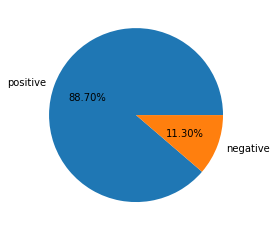

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt  
labels=['positive','negative']

X=[123769,15762] #movie_comment
# X=[1179936,783088]  #DSMC

fig = plt.figure()
plt.pie(X,labels=labels,autopct='%1.2f%%')

plt.show()  
plt.savefig("PieChart.jpg")

In [57]:
comment

Star                                            Comment
0         1                           爱你原本只是一瞬，却不知在时间的洪流中成了永恒。
1         1  那对对死无所畏惧的老夫妇，那个不为外界干扰的乐队，那个为生而做一次假父亲的男人，那个为爱人吹...
2         1         “我甚至连一张他的画像都没有，但他永远活在我心中。” 要敢说，这是我一直深爱的电影。
3         1  若干年后，2010年12月27日凌晨一点半，我不知道还有谁醒着没睡，还有谁和我一样，刚重温过...
4         1                       将永远是我在电影院所看过次数最多、最感动、也是最好的电影
...     ...                                                ...
151512    0                    看电影是一件无比私人的事，对这部电影我没有一丝情绪的波澜起伏。
151513    1                                         让人上头的晚年爱情啊
151514    1                                感受到了老无所依的难，温情才是最需要的
151515    1                                          8分，剧本好，好哭
151516    1                                         日月与朝夕，不及有你

[142064 rows x 2 columns]

In [58]:
# make an back-up copy, if we use sample data

#comment = pd.DataFrame(Review.values,columns=Review.columns)
#comment

In [59]:
# remove the number, punctuation

def preprocess(sentence):
    sentence=str(sentence)
    #sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    #filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in tokens]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(tokens)

comment['Comment'] = comment['Comment'].apply(preprocess)
comment.head()

Star                                            Comment
0    1                            爱你原本只是一瞬 却不知在时间的洪流中成了永恒
1    1  那对对死无所畏惧的老夫妇 那个不为外界干扰的乐队 那个为生而做一次假父亲的男人 那个为爱人吹...
2    1             我甚至连一张他的画像都没有 但他永远活在我心中 要敢说 这是我一直深爱的电影
3    1  若干年后 年月日凌晨一点半 我不知道还有谁醒着没睡 还有谁和我一样 刚重温过这片子 或是刚刚...
4    1                       将永远是我在电影院所看过次数最多 最感动 也是最好的电影

In [60]:
# we choose some moive frequent words as the add words to avoid wrong tokenization

# import jieba
# add_words = pd.read_excel("add_words.xlsx")

# for w in add_words.word:
#    jieba.add_word(w , freq=1000)

In [61]:
%%time
# use jieba to make tokenization, 

comment_s = []
for line in comment['Comment']:
    comment_cut = jieba.lcut(line)
    comment_s.append(comment_cut)

CPU times: total: 19.6 s
Wall time: 19.7 s


In [62]:
comment_s

[['爱',
  '你',
  '原本',
  '只是',
  '一瞬',
  ' ',
  '却',
  '不知',
  '在',
  '时间',
  '的',
  '洪流',
  '中成',
  '了',
  '永恒'],
 ['那',
  '对',
  '对',
  '死',
  '无所畏惧',
  '的',
  '老',
  '夫妇',
  ' ',
  '那个',
  '不',
  '为',
  '外界',
  '干扰',
  '的',
  '乐队',
  ' ',
  '那个',
  '为生',
  '而',
  '做',
  '一次',
  '假',
  '父亲',
  '的',
  '男人',
  ' ',
  '那个',
  '为',
  '爱人',
  '吹响',
  '口哨',
  '的',
  '女人',
  ' ',
  '都',
  '是',
  '为了',
  '一种',
  '心灵',
  '上',
  '的',
  '执着'],
 ['我',
  '甚至',
  '连',
  '一张',
  '他',
  '的',
  '画像',
  '都',
  '没有',
  ' ',
  '但',
  '他',
  '永远',
  '活',
  '在我心中',
  ' ',
  '要敢',
  '说',
  ' ',
  '这',
  '是',
  '我',
  '一直',
  '深爱',
  '的',
  '电影'],
 ['若干年',
  '后',
  ' ',
  '年月日',
  '凌晨',
  '一点半',
  ' ',
  '我',
  '不',
  '知道',
  '还有',
  '谁',
  '醒',
  '着',
  '没',
  '睡',
  ' ',
  '还有',
  '谁',
  '和',
  '我',
  '一样',
  ' ',
  '刚',
  '重温',
  '过',
  '这',
  '片子',
  ' ',
  '或是',
  '刚刚',
  '打开',
  '准备',
  '重温',
  ' ',
  '我',
  '又',
  '哭',
  '得',
  '很惨',
  ' ',
  '这是',
  '毫无疑问',
  '的',
  ' ',
  '我',
  '想',
  ' ',
  '之所以',

In [63]:
# delete some meaningless stop words

def get_custom_stopwords(stop_words_file):    
    with open(stop_words_file) as f:        
        stopwords = f.read()    
        stopwords_list = stopwords.split('\n')    
        custom_stopwords_list = [i for i in stopwords_list]    
    return custom_stopwords_list

In [64]:
#-*- coding : utf-8-*-
# coding:unicode_escape
io = "中文停用词库.txt"
#data=pd.read_csv(io,encoding='unicode_escape')
stopwords = pd.read_csv(io,encoding='utf-8')

In [65]:
stopwords

$
0    0
1    1
2    2
3    3
4    4
..  ..
740  ！
741  ，
742  ：
743  ；
744  ？

[745 rows x 1 columns]

In [66]:
# stop_words_file = "中文停用词库.txt"
# stopwords = get_custom_stopwords(stop_words_file)

In [67]:
%%time
comment_clean = []
for line in comment_s:
    line_clean = []
    for word in line:
        if word not in stopwords:
            line_clean.append(word)
    comment_clean.append(line_clean)

CPU times: total: 2.2 s
Wall time: 2.22 s


In [68]:
comment_clean

[['爱',
  '你',
  '原本',
  '只是',
  '一瞬',
  ' ',
  '却',
  '不知',
  '在',
  '时间',
  '的',
  '洪流',
  '中成',
  '了',
  '永恒'],
 ['那',
  '对',
  '对',
  '死',
  '无所畏惧',
  '的',
  '老',
  '夫妇',
  ' ',
  '那个',
  '不',
  '为',
  '外界',
  '干扰',
  '的',
  '乐队',
  ' ',
  '那个',
  '为生',
  '而',
  '做',
  '一次',
  '假',
  '父亲',
  '的',
  '男人',
  ' ',
  '那个',
  '为',
  '爱人',
  '吹响',
  '口哨',
  '的',
  '女人',
  ' ',
  '都',
  '是',
  '为了',
  '一种',
  '心灵',
  '上',
  '的',
  '执着'],
 ['我',
  '甚至',
  '连',
  '一张',
  '他',
  '的',
  '画像',
  '都',
  '没有',
  ' ',
  '但',
  '他',
  '永远',
  '活',
  '在我心中',
  ' ',
  '要敢',
  '说',
  ' ',
  '这',
  '是',
  '我',
  '一直',
  '深爱',
  '的',
  '电影'],
 ['若干年',
  '后',
  ' ',
  '年月日',
  '凌晨',
  '一点半',
  ' ',
  '我',
  '不',
  '知道',
  '还有',
  '谁',
  '醒',
  '着',
  '没',
  '睡',
  ' ',
  '还有',
  '谁',
  '和',
  '我',
  '一样',
  ' ',
  '刚',
  '重温',
  '过',
  '这',
  '片子',
  ' ',
  '或是',
  '刚刚',
  '打开',
  '准备',
  '重温',
  ' ',
  '我',
  '又',
  '哭',
  '得',
  '很惨',
  ' ',
  '这是',
  '毫无疑问',
  '的',
  ' ',
  '我',
  '想',
  ' ',
  '之所以',

In [69]:
%%time

# drop the duplicated words in one comment

comment_clean_dist = []
for line in comment_clean:   
   line_dist = []
   for word in line:
      if word not in line_dist:
         line_dist.append(word)
   comment_clean_dist.append(line_dist)

CPU times: total: 1.66 s
Wall time: 1.65 s


In [70]:
comment_clean_dist

[['爱',
  '你',
  '原本',
  '只是',
  '一瞬',
  ' ',
  '却',
  '不知',
  '在',
  '时间',
  '的',
  '洪流',
  '中成',
  '了',
  '永恒'],
 ['那',
  '对',
  '死',
  '无所畏惧',
  '的',
  '老',
  '夫妇',
  ' ',
  '那个',
  '不',
  '为',
  '外界',
  '干扰',
  '乐队',
  '为生',
  '而',
  '做',
  '一次',
  '假',
  '父亲',
  '男人',
  '爱人',
  '吹响',
  '口哨',
  '女人',
  '都',
  '是',
  '为了',
  '一种',
  '心灵',
  '上',
  '执着'],
 ['我',
  '甚至',
  '连',
  '一张',
  '他',
  '的',
  '画像',
  '都',
  '没有',
  ' ',
  '但',
  '永远',
  '活',
  '在我心中',
  '要敢',
  '说',
  '这',
  '是',
  '一直',
  '深爱',
  '电影'],
 ['若干年',
  '后',
  ' ',
  '年月日',
  '凌晨',
  '一点半',
  '我',
  '不',
  '知道',
  '还有',
  '谁',
  '醒',
  '着',
  '没',
  '睡',
  '和',
  '一样',
  '刚',
  '重温',
  '过',
  '这',
  '片子',
  '或是',
  '刚刚',
  '打开',
  '准备',
  '又',
  '哭',
  '得',
  '很惨',
  '这是',
  '毫无疑问',
  '的',
  '想',
  '之所以',
  '情愿',
  '活着',
  '是因为',
  '没有',
  '那个',
  '如此',
  '相爱',
  '想要',
  '厮守',
  '人',
  '死去',
  '一个',
  '爱',
  '值得',
  '为',
  '他',
  '去',
  '死'],
 ['将',
  '永远',
  '是',
  '我',
  '在',
  '电影院',
  '所',
  '看过',
  '次数',
  '最'

In [71]:
%%time

# calculate the the length of each review
len_line = []
for line in comment_clean_dist:
    length = len(line)
    len_line.append(length)

CPU times: total: 31.2 ms
Wall time: 25 ms


In [72]:
# put all reviews in one list 

allwords_clean_dist = []
for line in comment_clean_dist:
   for word in line:
      allwords_clean_dist.append(word)

In [73]:
allwords_clean_dist

['爱',
 '你',
 '原本',
 '只是',
 '一瞬',
 ' ',
 '却',
 '不知',
 '在',
 '时间',
 '的',
 '洪流',
 '中成',
 '了',
 '永恒',
 '那',
 '对',
 '死',
 '无所畏惧',
 '的',
 '老',
 '夫妇',
 ' ',
 '那个',
 '不',
 '为',
 '外界',
 '干扰',
 '乐队',
 '为生',
 '而',
 '做',
 '一次',
 '假',
 '父亲',
 '男人',
 '爱人',
 '吹响',
 '口哨',
 '女人',
 '都',
 '是',
 '为了',
 '一种',
 '心灵',
 '上',
 '执着',
 '我',
 '甚至',
 '连',
 '一张',
 '他',
 '的',
 '画像',
 '都',
 '没有',
 ' ',
 '但',
 '永远',
 '活',
 '在我心中',
 '要敢',
 '说',
 '这',
 '是',
 '一直',
 '深爱',
 '电影',
 '若干年',
 '后',
 ' ',
 '年月日',
 '凌晨',
 '一点半',
 '我',
 '不',
 '知道',
 '还有',
 '谁',
 '醒',
 '着',
 '没',
 '睡',
 '和',
 '一样',
 '刚',
 '重温',
 '过',
 '这',
 '片子',
 '或是',
 '刚刚',
 '打开',
 '准备',
 '又',
 '哭',
 '得',
 '很惨',
 '这是',
 '毫无疑问',
 '的',
 '想',
 '之所以',
 '情愿',
 '活着',
 '是因为',
 '没有',
 '那个',
 '如此',
 '相爱',
 '想要',
 '厮守',
 '人',
 '死去',
 '一个',
 '爱',
 '值得',
 '为',
 '他',
 '去',
 '死',
 '将',
 '永远',
 '是',
 '我',
 '在',
 '电影院',
 '所',
 '看过',
 '次数',
 '最',
 '多',
 ' ',
 '感动',
 '也',
 '最好',
 '的',
 '电影',
 '学校',
 '组织',
 '放映',
 '的',
 '影片',
 ' ',
 '大家',
 '好像',
 '对',
 'rose',
 '和',
 'jack',
 '恋爱

In [74]:
# make a dataframe to count the frequency

df_allwords_clean_dist = pd.DataFrame({'allwords': allwords_clean_dist})
word_count = df_allwords_clean_dist.allwords.value_counts().reset_index()    
word_count.columns = ['word','count'] 

In [75]:
word_count

word   count
0             103155
1          的   88745
2          了   47103
3          是   39106
4          我   28640
...      ...     ...
106501   休斯顿       1
106502    电气       1
106503  通用电气       1
106504  三十余年       1
106505    變老       1

[106506 rows x 2 columns]

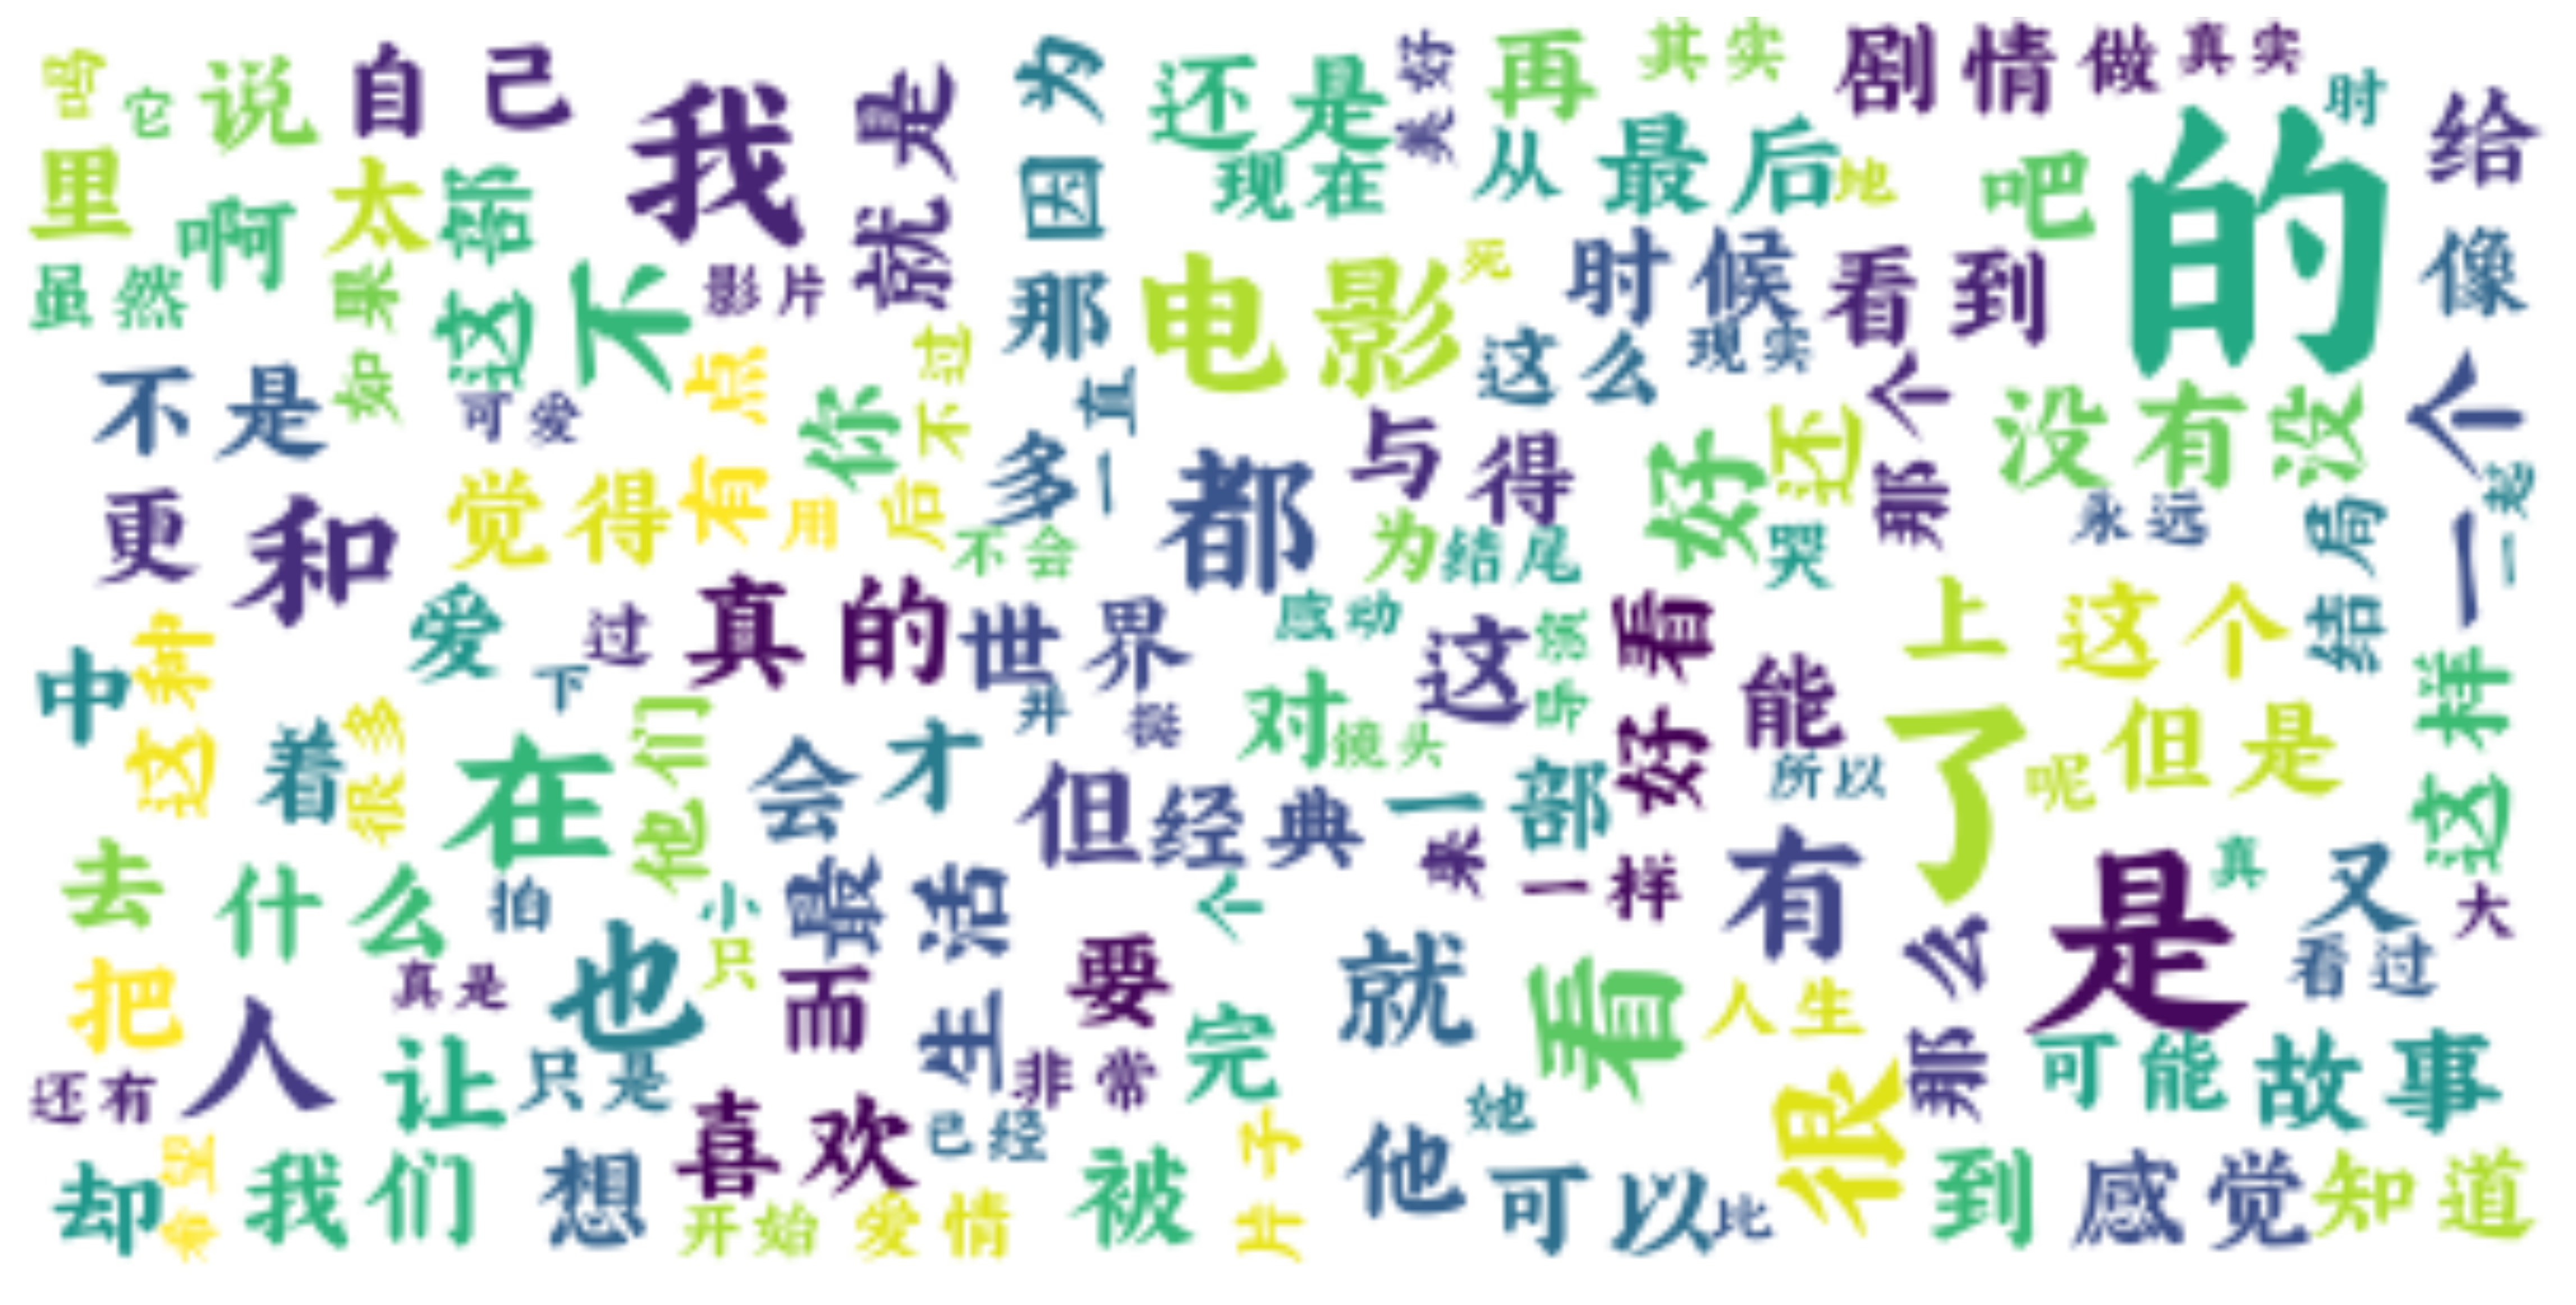

In [79]:
# use the most frequent words to draw word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt
    
plt.figure(figsize=(20,10), dpi = 300)
w_c = WordCloud(font_path=r"E:\字体\FZZJ-ZYGDKJW-2.TTF",background_color="white", 
                max_font_size=60, margin=1)
wc = w_c.fit_words({x[0]:x[1] for x in word_count.head(150).values})    

plt.imshow(wc, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [ ]:
# transform comment_clean_dist to only one list that using commas fragments each comment

All_text = []
for line in comment_clean_dist:
    onetext = " ".join(line)
    All_text.append(onetext)
All_text

['连 奥创 都 知道 整容 要 去 韩国',
 '非常 失望   剧本 完全 敷衍了事 主线 剧情 没 突破 大家 可以 理解 可 所有 的 人物 都 缺乏 动机 正邪 之间 妇联 内部 没什么 火花 团结 分裂 三段式 虽然 老套 但 其实 也 利用 积攒 下来 形象 魅力 搞 出 意思 写得 肤浅 平面 场面 上 调度 混乱 呆板 满屏 铁甲 审美疲劳 只有 笑 点算 得 差强人意',
 '年度 最 失望 作品   以为 面面俱到 实则 画蛇添足 主题深刻 老调重弹 推陈出新 俗不可耐 场面 很 high 劲 不足 气 上 一集 的 趣味 全无 这集 笑 点 明显 刻意 到 心虚 全片 没有 任何 片段 给 我 有 紧张 激动 时候 太弱 了 跟 奥创 一样',
 '铁人   中 勾引 钢铁 侠 妇联 鹰眼 美队 美国 队长 在 终于 跟 绿巨人 表白 了 黑寡妇 用 实际行动 告诉 我们 什么 叫 忠贞不二 而且 为了 治疗 不孕 不育 连 作战 武器 都 变成 两支 验孕 棒 坚决 相信 快银 没有 死 后面 还 得 回来',
 '虽然 从头 打到 尾   但是 真的 很 无聊 啊',
 '剧情 不如 第一集 好玩 了   全靠 密集 笑点 在 提神 僧多粥少 的 直接 后果 就是 每部 寡姐 都 要 换 着 队友 谈恋爱 这特 么 比 打斗 还 辛苦 啊 真心 求 放过 结尾 彩蛋 以为 是 洛基 呢 结果 我 呸',
 '只有 一颗 彩蛋 必须 降一星   外加 漫威 的 编剧 是 有心无力 了 吧 复仇者 联盟 只能 永远 着手 与 团队 和 不 这种 东西 重复 到 第二次 就是 隔 三年 还是 心有余而力不足 只好 来 三个 新 成员 但是 认真 地 有 必要 加 一条 家庭 线 么 妇联 以后 也 要 走 赛车 帮 we are familly 路线',
 '看腻 了 这些 打来打去 的 烂片',
 '漫威粉 勿 喷   真 感觉 比 第一部 差 了 些 火候 没想到 奥创 竟然 这么 弱 出来 失望 之极',
 '属于 超级 英雄 的 春晚   角色 如 走马灯 一样 出场 眼花缭乱 同时 却 没 办法 给 人 留下 太深 印象 这部 内容 实在 太多 了 这么 多 各有 黑暗 历史 又 为 之后 铺垫 弄 得 每个 都 很 单薄 好 在 动

In [ ]:
# using All_text value make a dataframe

df_all_text = pd.DataFrame(All_text, columns = ['Comment'])
df_all_text

Comment
0                                      连 奥创 都 知道 整容 要 去 韩国
1        非常 失望   剧本 完全 敷衍了事 主线 剧情 没 突破 大家 可以 理解 可 所有 的 ...
2        年度 最 失望 作品   以为 面面俱到 实则 画蛇添足 主题深刻 老调重弹 推陈出新 俗不...
3        铁人   中 勾引 钢铁 侠 妇联 鹰眼 美队 美国 队长 在 终于 跟 绿巨人 表白 了 ...
4                                虽然 从头 打到 尾   但是 真的 很 无聊 啊
...                                                    ...
1963019  真 好看   兔子 警官 又 美有 善良 可爱 简直 理想 结婚 对象 每 一个 动物 造型...
1963020                             六星 好评   像 头脑 特工队 那样 惊喜
1963021                        欢乐 而 又 深刻   是 童话故事 更是 政治 寓言
1963022  对 现实 世界 歧视 和 偏见 的 影射 妙哉   不要 害怕 打破常规 try every...
1963023  萌物 包装 的 政治 正确 片   那个 叫 Doug 穿 黄衫 戴 防毒面具 绵羊 助手 ...

[1963024 rows x 1 columns]

In [ ]:
df_all_text['Comment']

0                                        连 奥创 都 知道 整容 要 去 韩国
1          非常 失望   剧本 完全 敷衍了事 主线 剧情 没 突破 大家 可以 理解 可 所有 的 ...
2          年度 最 失望 作品   以为 面面俱到 实则 画蛇添足 主题深刻 老调重弹 推陈出新 俗不...
3          铁人   中 勾引 钢铁 侠 妇联 鹰眼 美队 美国 队长 在 终于 跟 绿巨人 表白 了 ...
4                                  虽然 从头 打到 尾   但是 真的 很 无聊 啊
                                 ...                        
1963019    真 好看   兔子 警官 又 美有 善良 可爱 简直 理想 结婚 对象 每 一个 动物 造型...
1963020                               六星 好评   像 头脑 特工队 那样 惊喜
1963021                          欢乐 而 又 深刻   是 童话故事 更是 政治 寓言
1963022    对 现实 世界 歧视 和 偏见 的 影射 妙哉   不要 害怕 打破常规 try every...
1963023    萌物 包装 的 政治 正确 片   那个 叫 Doug 穿 黄衫 戴 防毒面具 绵羊 助手 ...
Name: Comment, Length: 1963024, dtype: object

In [ ]:
comment['Star']

0          0
1          0
2          0
3          1
4          0
          ..
2125051    1
2125052    1
2125053    1
2125054    1
2125055    1
Name: Star, Length: 1963024, dtype: object

In [ ]:
# spilting data to train and test data set

# text = df_all_text['Comment']
# score = comment['Star']

text = df_all_text['Comment']
score = comment['Star']
X_train1, X_test1, y_train1, y_test1 = train_test_split(text, score, test_size=0.3, random_state=0) 
# X_train1, X_test1, y_train1, y_test1 = train_test_split(text, score, test_size = 0.20, random_state = 0, stratify = score)

In [ ]:
# convert corpus to BoW format

from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer(encoding='latin-1')
X_train_counts = count_vect.fit_transform(X_train1)
X_train_counts.shape

(1374116, 258344)

In [ ]:
#calculate tf-idf and use tf-idfs to represent documents

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_train_tfidf.shape

(1374116, 258344)

In [ ]:
X_train_tfidf

<1374116x258344 sparse matrix of type '<class 'numpy.float64'>'
	with 15745166 stored elements in Compressed Sparse Row format>

## 2.Using ti-idfs as independent variables to predict the sentiment

We first tried to build lda and lsa topic models to make prediction(the same as project 3 method), but the result is not ideal. No mather we used either model, the probability of prediction is around the random guess's probability. Therefore, we move our direction to using ti-idfs as dependent variables to build our model after refering to other nlp sentiment prediction projects. We uses several classification models, then print out their classification report and draw ROC plot. We choose the best model according to both the f1-score and AUC score.

### Multinomial NB

In [ ]:
# build MultinomialNB model

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train1)

In [ ]:
# fit MultinomialNB model

from sklearn.metrics import accuracy_score, confusion_matrix
X_test_counts = count_vect.transform(X_test1)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pre1 = clf.predict(X_test_tfidf)
gaussian_acc = accuracy_score(y_test1, y_pre1)
print(gaussian_acc)

0.7650278141916904


In [ ]:
# print the classification report and confustion report

print("Classification Report:\n ", classification_report(y_test1, y_pre1))
print("Confusion Matrix:\n ", confusion_matrix(y_test1, y_pre1))

Classification Report:
                precision    recall  f1-score   support

           0       0.78      0.57      0.66    235078
           1       0.76      0.89      0.82    353830

    accuracy                           0.77    588908
   macro avg       0.77      0.73      0.74    588908
weighted avg       0.77      0.77      0.76    588908

Confusion Matrix:
  [[133987 101091]
 [ 37286 316544]]


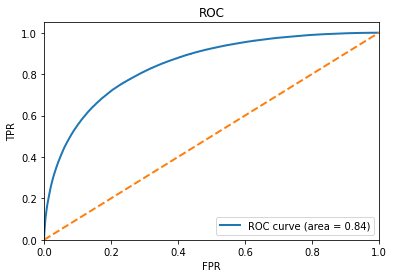

In [ ]:
# draw the ROC plot and calculate AUC score

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

y_pred11 = clf.predict_proba(X_test_tfidf)
(fpr, tpr, thresholds) = roc_curve(y_test1,y_pred11[:,1],pos_label='1')
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

In [ ]:
# cross-validation to find the best parameter

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

random_search = {'C':[0.01, 1, 10, 100]}
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=random_search, cv=4, n_jobs=-1, scoring='roc_auc')
grid_result=grid_search.fit(X_train_tfidf, y_train1)
print(f'Best:{grid_result.best_score_}using{grid_result.best_params_}','\n')

MemoryError: Unable to allocate 15.0 MiB for an array with shape (3936853,) and data type int32

In [ ]:
lr = LogisticRegression(C=1)
lr.fit(X_train_tfidf, y_train1)
y_pre2 = lr.predict(X_test_tfidf)
logistic_acc = accuracy_score(y_test1, y_pre2)
print(logistic_acc)

0.779954407101285


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
print("Classification Report:\n ", classification_report(y_test1, y_pre2))
print("Confusion Matrix:\n ", confusion_matrix(y_test1, y_pre2))

Classification Report:
                precision    recall  f1-score   support

           0       0.75      0.66      0.71    156618
           1       0.79      0.86      0.82    235987

    accuracy                           0.78    392605
   macro avg       0.77      0.76      0.77    392605
weighted avg       0.78      0.78      0.78    392605

Confusion Matrix:
  [[104148  52470]
 [ 33921 202066]]


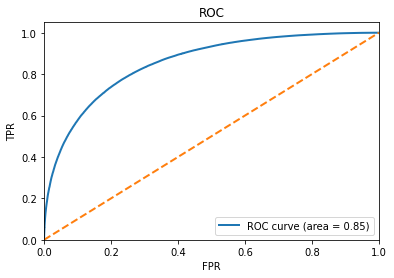

In [ ]:
y_pred11 = lr.predict_proba(X_test_tfidf)
(fpr, tpr, thresholds) = roc_curve(y_test1,y_pred11[:,1],pos_label='1')
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Linear SVM

In [ ]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train1)
y_pred4 = svm.predict(X_test_tfidf)

print("Classification Report:\n ", classification_report(y_test1, y_pred4))
print("Confusion Matrix:\n ", confusion_matrix(y_test1, y_pred4))

Classification Report:
                precision    recall  f1-score   support

           0       0.74      0.66      0.70    156618
           1       0.79      0.85      0.82    235987

    accuracy                           0.77    392605
   macro avg       0.77      0.76      0.76    392605
weighted avg       0.77      0.77      0.77    392605

Confusion Matrix:
  [[103748  52870]
 [ 35628 200359]]


### Perception

In [ ]:
from sklearn.linear_model import Perceptron
model5=Perceptron()
model5.fit(X_train_tfidf, y_train1)
y_pred5 = model5.predict(X_test_tfidf)

print("Classification Report:\n ", classification_report(y_test1, y_pred5))
print("Confusion Matrix:\n ", confusion_matrix(y_test1, y_pred5))

Classification Report:
                precision    recall  f1-score   support

           0       0.63      0.63      0.63    156618
           1       0.76      0.75      0.75    235987

    accuracy                           0.70    392605
   macro avg       0.69      0.69      0.69    392605
weighted avg       0.71      0.70      0.70    392605

Confusion Matrix:
  [[ 99247  57371]
 [ 58528 177459]]


### MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
model7 = MLPClassifier(hidden_layer_sizes=(400,100),alpha=0.01,max_iter=1000) 
model7.fit(X_train_tfidf, y_train1) 
y_pred7 = model7.predict(X_test_tfidf)

print("Classification Report:\n ", classification_report(y_test1, y_pred7))

Classification Report:
                precision    recall  f1-score   support

           0       0.75      0.44      0.56    156618
           1       0.71      0.90      0.79    235987

    accuracy                           0.72    392605
   macro avg       0.73      0.67      0.68    392605
weighted avg       0.73      0.72      0.70    392605



### GradientBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model6= GradientBoostingClassifier(random_state=1)             
model6.fit(X_train_tfidf, y_train1)           

GradientBoostingClassifier(random_state=1)

In [ ]:
y_pred6 = model6.predict(X_test_tfidf)

print("Classification Report:\n ", classification_report(y_test1, y_pred6))
print("Confusion Matrix:\n ", confusion_matrix(y_test1, y_pred6))

Classification Report:
                precision    recall  f1-score   support

           0       0.80      0.22      0.34    156618
           1       0.65      0.96      0.78    235987

    accuracy                           0.67    392605
   macro avg       0.73      0.59      0.56    392605
weighted avg       0.71      0.67      0.60    392605

Confusion Matrix:
  [[ 34306 122312]
 [  8490 227497]]


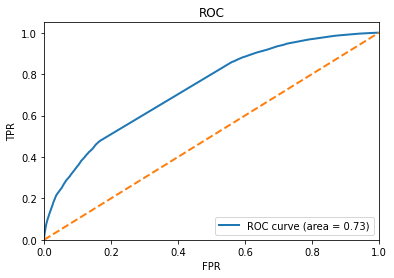

In [ ]:
y_pred11 = model6.predict_proba(X_test_tfidf)
(fpr, tpr, thresholds) = roc_curve(y_test1,y_pred11[:,1],pos_label='1')
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### AdaBoost

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier
import sklearn.tree as st
import sklearn.ensemble as se
model10=AdaBoostClassifier(n_estimators=150, random_state=0)
model10.fit(X_train_tfidf, y_train1) 
y_pred10 = model10.predict(X_test_tfidf)

print("Classification Report:\n ", classification_report(y_test1, y_pred10))
print("Confusion Matrix:\n ", confusion_matrix(y_test1, y_pred10))

Classification Report:
                precision    recall  f1-score   support

           0       0.70      0.46      0.55    156618
           1       0.71      0.87      0.78    235987

    accuracy                           0.71    392605
   macro avg       0.71      0.66      0.67    392605
weighted avg       0.71      0.71      0.69    392605

Confusion Matrix:
  [[ 71309  85309]
 [ 29858 206129]]
CPU times: total: 10min 36s
Wall time: 10min 37s


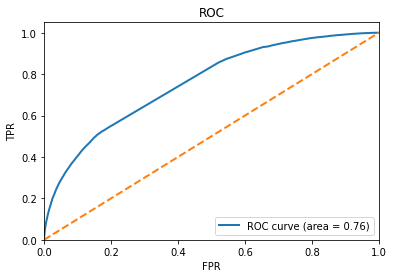

In [ ]:
y_pred11 = model10.predict_proba(X_test_tfidf)
(fpr, tpr, thresholds) = roc_curve(y_test1,y_pred11[:,1],pos_label='1')
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 3.Build the LSA and LDA topic models for the reviews

We use two models LDA and LSA to handle the review documents. For each model, we use the corpus after applying tf-idf and dictionary to fit the model and get several topics. Secondly, we use coherence values to find the optimal topic number.Coherence value help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. So we use that with highest score to decide the number of topic. Then, we print the topics and the score of each topic for the reviews.

### LDA-choose the topic number
We first choose the optimal topic number.

In [ ]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
dictionary= corpora.Dictionary(comment_clean)  # fit dictionary
dictionary
corpus = [dictionary.doc2bow(line) for line in comment_clean]  # convert corpus to BoW format

In [ ]:
%%time
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3): #def2
    coherence_values = []
    model_list = []
    for num_of_topics in range(start, stop, step):
        # generate LDA model
        print(num_of_topics)
        model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=num_of_topics, id2word = dictionary,random_state = 1)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    print(coherence_values)
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step): #def3
    #dictionary
    model_list, coherence_values = compute_coherence_values(dictionary,corpus,text,stop, start, step) #def2
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
text = comment_clean
start,stop,step=1,6,1
plot_graph(text,start,stop,step)
#print()
# We got 4 is the optimal number for the topic choosen.

1


In [ ]:
plt.savefig('lda_best_topics.png')

NameError: name 'plt' is not defined

### LDA-build the model

In [ ]:
nt = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=nt, id2word = dictionary, passes=2) 

print(lda_model.print_topics(num_topics=nt, num_words=5))

ValueError: cannot compute LDA over an empty collection (no terms)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

NameError: name 'lda_model' is not defined

### LSA-choose the topic number

In [ ]:
%%time
from gensim.models import LsiModel
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3): #def2
    coherence_values = []
    model_list = []
    for num_of_topics in range(start, stop, step):
        # generate LSA model
        print(num_of_topics)
        model = LsiModel(doc_term_matrix, num_topics=num_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    print(coherence_values)
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step): #def3
    #dictionary
    model_list, coherence_values = compute_coherence_values(dictionary,corpus,text,stop, start, step) #def2
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
text = comment_clean
start,stop,step=1,6,1
plot_graph(text,start,stop,step)
#print()
# We got 3 is the optimal number for the topic choosen.

NameError: name 'comment_clean' is not defined

### LSA-build the model

In [ ]:
nt = 3
lsa_model = LsiModel(corpus, num_topics=nt, id2word = dictionary) 

print(lsa_model.print_topics(num_topics=nt, num_words=10))

TypeError: object of type 'NoneType' has no len()

In [ ]:
for idx, topic in lsa_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

TypeError: object of type 'NoneType' has no len()

## 4.Now, let's use a new film 'Frozen' to test our model!

In [ ]:
dataset = pd.read_csv("doubanmovieshortcomments/movie_comment.csv", sep='\t', header=None, encoding='utf-8')
dataset

ParserError: Error tokenizing data. C error: Expected 1 fields in line 11407, saw 12


In [ ]:
dataset[0]=((dataset[0]+0.5)/3.5).astype(int)

NameError: name 'dataset' is not defined

In [ ]:
def preprocess(sentence):
    sentence=str(sentence)
    #sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    #filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in tokens]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(tokens)

In [ ]:
comment_s1 = []
for line in dataset[1]:
    comment_cut = jieba.lcut(line)
    comment_s1.append(comment_cut)

NameError: name 'dataset' is not defined

In [ ]:
comment_clean1 = []
for line in comment_s1:
    line_clean = []
    for word in line:
        if word not in stopwords:
            line_clean.append(word)
    comment_clean1.append(line_clean)

In [ ]:
comment_clean_dist1 = []
for line in comment_clean1:   
   line_dist = []
   for word in line:
      if word not in line_dist:
         line_dist.append(word)
   comment_clean_dist1.append(line_dist)

In [ ]:
allwords_clean_dist1 = []
for line in comment_clean_dist1:
   for word in line:
      allwords_clean_dist1.append(word)

In [ ]:
All_text1 = []
for line in comment_clean_dist1:
    onetext = " ".join(line)
    All_text1.append(onetext)

In [ ]:
df_all_text1 = pd.DataFrame(All_text1, columns = ['Comment'])
df_all_text1

Empty DataFrame
Columns: [Comment]
Index: []

In [ ]:
X_test_bxqy=df_all_text1.Comment
y_test_bxqy=dataset[0]

y_test_bxqy=y_test_bxqy.astype("str")

NameError: name 'dataset' is not defined

In [ ]:
X_test_bxqy_counts = count_vect.transform(X_test_bxqy)
X_test_bxqy_tfidf = tfidf_transformer.transform(X_test_bxqy_counts)

NotFittedError: Vocabulary not fitted or provided

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train1)
y_predlr_bxqy = lr.predict(X_test_bxqy_tfidf)

print("Classification Report:\n ", classification_report(y_test_bxqy, y_predlr_bxqy))
print("\nConfusion Matrix:\n",metrics.confusion_matrix(y_test_bxqy, y_predlr_bxqy))

NameError: name 'X_train_tfidf' is not defined

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [ ]:
y_pred11 = lr.predict_proba(X_test_bxqy_tfidf)
(fpr, tpr, thresholds) = roc_curve(y_test_bxqy,y_pred11[:,1],pos_label='1')
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

NameError: name 'X_test_bxqy_tfidf' is not defined

In [ ]:
X_train_scaled=X_train_tfidf
X_test_scaled=X_test_bxqy_tfidf
y_test=y_test_bxqy
y_train=y_train1

from sklearn.naive_bayes import BernoulliNB
model17 = BernoulliNB()
model17.fit(X_train_scaled, y_train)
y_pred17 = model17.predict(X_test_scaled)

print("Classification Report:\n ", classification_report(y_test, y_pred17))
print("\nConfusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred17))

NameError: name 'X_train_tfidf' is not defined

In [ ]:
y_pred11 = model17.predict_proba(X_test_bxqy_tfidf)
(fpr, tpr, thresholds) = roc_curve(y_test_bxqy,y_pred11[:,1],pos_label='1')
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

NameError: name 'model17' is not defined